# **Hierarchical Reinforcement Learning with FINBERT Integration for Portfolio Management**

# Setup

In [1]:
# install dependencies
!pip install -q gymnasium stable-baselines3 yfinance asyncpraw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 7.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.19.0 requires aiosqlite>=0.21.0, but you have aiosqlite 0.17.0 which is incompatible.


In [2]:
# imports
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, SAC, DDPG, TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.utils import set_random_seed
import torch
import torch.nn as nn
import torch.optim as optim
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

import asyncpraw
from transformers import AutoTokenizer, AutoModelForSequenceClassification



Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:
# configuration
class Config:
    # assets and ticker symbols
    TICKERS = {
        'SP500': '^GSPC',      # S&P 500
        'NASDAQ': '^IXIC',     # NASDAQ
        'DOW': '^DJI',         # Dow Jones
        'RUSSELL': '^RUT',     # Russell 2000
        'GOLD': 'GC=F',        # Gold Futures
        'SILVER': 'SI=F',      # Silver Futures
        'OIL': 'CL=F'          # Crude Oil WTI
    }

    # assets and reddit search terms
    REDDIT_KEYWORDS = {
        'SP500': ['S&P 500', 'SPY', 'SP500', 'S&P', 'VOO'],
        'NASDAQ': ['NASDAQ', 'QQQ', 'tech stocks'],
        'DOW': ['Dow Jones', 'DIA', 'DJIA'],
        'RUSSELL': ['Russell 2000', 'IWM', 'small cap'],
        'GOLD': ['gold', 'GLD', 'gold prices'],
        'SILVER': ['silver', 'SLV', 'silver prices'],
        'OIL': ['oil', 'crude oil', 'USO', 'WTI']
    }

    # train on previous two year
    TRAIN_START = '2022-01-01'
    TRAIN_END = '2024-12-31'

    # test on year to date
    TEST_START = '2025-01-01'
    TEST_END = '2025-11-28'

    # parameters
    N_ASSETS = len(TICKERS)
    TIMESTEPS_BASE = 30000
    TIMESTEPS_META = 15000
    TIMESTEPS_SUPER = 10000

    ALPHA_ROI = 1.0
    ALPHA_VOLATILITY = 0.5
    ALPHA_DRAWDOWN = 2.0


config = Config()
print(f"Configuration: {config.N_ASSETS} US assets")
print(f"Training: {config.TRAIN_START} to {config.TRAIN_END}")
print(f"Testing: {config.TEST_START} to {config.TEST_END}")


Configuration: 7 US assets
Training: 2022-01-01 to 2024-12-31
Testing: 2025-01-01 to 2025-11-28


In [4]:
import os, random

SEED = 12

def set_global_seed(seed=43):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # for maximum determinism (slower)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_global_seed(SEED)
set_random_seed(SEED)



In [5]:
# reddit creds
CLIENT_ID = "aq-2pxMG9ttgc4SWXu_QTw"
CLIENT_SECRET = "lBnvo65CKWRFbE7XGM8AXkPNXj7X6g"
USERNAME = "Sad_View_5744"
PASSWORD = "Aditya@2001"

In [6]:
from google.colab import userdata

try:
    REDDIT_CLIENT_ID = CLIENT_ID
    REDDIT_CLIENT_SECRET = CLIENT_SECRET
    REDDIT_USERNAME = USERNAME
    REDDIT_PASSWORD = PASSWORD

    print("Reddit credentials loaded")

except Exception as e:
    print(f"Could not load Reddit credentials: {e}")

Reddit credentials loaded


In [7]:
# get market data
def download_market_data(start_date: str, end_date: str) -> pd.DataFrame:
    print(f"Downloading data from {start_date} to {end_date}...")

    price_series_list = []
    asset_names = []

    for asset, ticker in config.TICKERS.items():
        print(f"Downloading {asset:10s} ({ticker})...", end=" ")
        try:
            # get raw data
            raw_data = yf.download(ticker, start=start_date, end=end_date, progress=False)

            # check if data exists
            if raw_data.empty:
                print(f"No data")
                continue

            # close price
            if isinstance(raw_data.columns, pd.MultiIndex):
                close_prices = raw_data['Close'].iloc[:, 0] if 'Close' in raw_data.columns.get_level_values(0) else None
            else:
                close_prices = raw_data['Close'] if 'Close' in raw_data.columns else None

            if close_prices is not None and len(close_prices) > 0:
                close_prices.name = asset
                price_series_list.append(close_prices)
                asset_names.append(asset)
                print(f"{len(close_prices)} days")
            else:
                print(f"No Close column")

        except Exception as e:
            print(f"Error: {str(e)[:40]}")

    if not price_series_list:
        print("\nError: No data downloaded for any asset!")
        return pd.DataFrame()

    # move to dataframe
    prices_df = pd.concat(price_series_list, axis=1)

    # fill missing values
    prices_df = prices_df.fillna(method='ffill').fillna(method='bfill')

    print(f"\nDownloaded {len(prices_df)} days for {len(asset_names)} assets")
    print(f"Date range: {prices_df.index[0].date()} to {prices_df.index[-1].date()}")
    print(f"Assets: {asset_names}")

    return prices_df

# download train and test data
print("=" * 80)
print("DOWNLOADING MARKET DATA")
print("=" * 80)

train_prices = download_market_data(config.TRAIN_START, config.TRAIN_END)
print()
test_prices = download_market_data(config.TEST_START, config.TEST_END)

# validate data
print("\n" + "=" * 80)
print("DATA VALIDATION")
print("=" * 80)

if train_prices.empty:
    print("\nError: Training data is empty!")
else:
    print(f"\nTraining data: {train_prices.shape}")
    print(f"Dates: {train_prices.index[0].date()} to {train_prices.index[-1].date()}")
    print(f"Latest prices:")
    for col in train_prices.columns:
        latest_price = train_prices[col].iloc[-1]
        print(f"{col:10s}: ${latest_price:>10.2f}")

if test_prices.empty:
    print("\nError: Test data is empty!")
else:
    print(f"\nTest data: {test_prices.shape}")
    print(f"Dates: {test_prices.index[0].date()} to {test_prices.index[-1].date()}")

print("\n" + "=" * 80)


DOWNLOADING MARKET DATA

Downloaded 752 days for 7 assets
Date range: 2022-01-03 to 2024-12-30
Assets: ['SP500', 'NASDAQ', 'DOW', 'RUSSELL', 'GOLD', 'SILVER', 'OIL']


Downloaded 229 days for 7 assets
Date range: 2025-01-02 to 2025-11-26
Assets: ['SP500', 'NASDAQ', 'DOW', 'RUSSELL', 'GOLD', 'SILVER', 'OIL']

DATA VALIDATION

Training data: (752, 7)
Dates: 2022-01-03 to 2024-12-30
Latest prices:
SP500     : $   5906.94
NASDAQ    : $  19486.79
DOW       : $  42573.73
RUSSELL   : $   2227.78
GOLD      : $   2606.10
SILVER    : $     29.11
OIL       : $     70.99

Test data: (229, 7)
Dates: 2025-01-02 to 2025-11-26



In [8]:
# other financial features
def compute_data_features(prices: pd.DataFrame, window: int = 30) -> Tuple[np.ndarray, pd.DatetimeIndex]:
    returns = prices.pct_change().dropna()
    n_assets = len(prices.columns)

    features_list = []

    for i in range(window, len(returns)):
        window_returns = returns.iloc[i-window:i]

        # sharpe ratio
        sharpe = (window_returns.mean() / (window_returns.std() + 1e-8)) * np.sqrt(252)

        # sortino ratio
        downside_returns = window_returns[window_returns < 0]
        sortino = (window_returns.mean() / (downside_returns.std() + 1e-8)) * np.sqrt(252)

        # calmar ratio
        cumulative = (1 + window_returns).cumprod()
        max_dd = (cumulative / cumulative.cummax() - 1).min()
        calmar = window_returns.mean() * 252 / (abs(max_dd) + 1e-8)

        # volatility
        volatility = window_returns.std() * np.sqrt(252)

        # correlation matrix
        corr_matrix = window_returns.corr().values
        corr_flat = corr_matrix[np.triu_indices_from(corr_matrix, k=1)]

        # create full vector of all computed features
        feature_vector = np.concatenate([
            sharpe.values,
            sortino.values,
            calmar.values,
            max_dd.values,
            volatility.values,
            corr_flat
        ])
        feature_vector = np.nan_to_num(feature_vector, nan=0.0, posinf=0.0, neginf=0.0)
        features_list.append(feature_vector)

    return np.array(features_list), returns.iloc[window:].index

print("Computing data-driven features...")
train_data_features, train_dates = compute_data_features(train_prices)
test_data_features, test_dates = compute_data_features(test_prices)

print(f"Data features shape: {train_data_features.shape}")
print(f"Feature dimension: {train_data_features.shape[1]}")
print(f"Expected: {5*config.N_ASSETS + (config.N_ASSETS*(config.N_ASSETS-1))//2} = {train_data_features.shape[1]}")


Computing data-driven features...
Data features shape: (721, 56)
Feature dimension: 56
Expected: 56 = 56


# NLP with FinBERT

In [9]:
# scrape reddit posts and analyze with FinBERT
async def scrape_reddit_sentiment(start_date: str, end_date: str) -> Dict[str, List[float]]:
    print("=" * 80)
    print("SCRAPING REDDIT FOR REAL SENTIMENT DATA")
    print("=" * 80)

    try:
        reddit = asyncpraw.Reddit(
            client_id=REDDIT_CLIENT_ID,
            client_secret=REDDIT_CLIENT_SECRET,
            user_agent="PortfolioRL/1.0",
            username=REDDIT_USERNAME,
            password=REDDIT_PASSWORD
        )

        user = await reddit.user.me()
        print(f"\nAuthenticated as: {user.name}\n")

        print("Loading FinBERT model...")
        tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
        model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
        model.eval()

        if torch.cuda.is_available():
            model = model.to('cuda')

        subreddits = ['stocks', 'investing', 'wallstreetbets', 'StockMarket']

        # collect posts for each asset
        all_sentiment_data = {asset: [] for asset in config.TICKERS.keys()}

        for subreddit_name in subreddits:
            print(f"Scraping r/{subreddit_name}...")
            try:
                subreddit = await reddit.subreddit(subreddit_name)

                async for submission in subreddit.new(limit=500):
                    title = submission.title
                    body = submission.selftext[:500] if submission.selftext else ""
                    content = title + " " + body

                    # check for mentioned asset keywords
                    for asset, keywords in config.REDDIT_KEYWORDS.items():
                        if any(kw.lower() in content.lower() for kw in keywords):
                            # analyze with FinBert
                            inputs = tokenizer(content[:512], return_tensors="pt",
                                             truncation=True, padding=True)

                            if torch.cuda.is_available():
                                inputs = {k: v.to('cuda') for k, v in inputs.items()}

                            with torch.no_grad():
                                outputs = model(**inputs)

                            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
                            # FinBERT outputs: [positive, negative, neutral]
                            sentiment_score = probs[0][0].item() - probs[0][1].item()  # pos - neg

                            all_sentiment_data[asset].append({
                                'score': sentiment_score,
                                'confidence': probs.max().item(),
                                'text_length': len(content)
                            })

                print(f"Scraped r/{subreddit_name}")

            except Exception as e:
                print(f"Error with r/{subreddit_name}: {e}")

        # aggregate by asset
        print(f"\n{'Asset':<10} {'Posts':<8} {'Avg Sentiment':<15} {'Confidence'}")
        print("-" * 50)

        aggregated = {}
        for asset, data in all_sentiment_data.items():
            if len(data) > 0:
                avg_sentiment = np.mean([d['score'] for d in data])
                avg_confidence = np.mean([d['confidence'] for d in data])
                aggregated[asset] = {
                    'sentiment': avg_sentiment,
                    'confidence': avg_confidence,
                    'count': len(data),
                    'volatility': np.std([d['score'] for d in data])
                }
                print(f"{asset:<10} {len(data):<8} {avg_sentiment:>+.3f}          {avg_confidence:.3f}")
            else:
                aggregated[asset] = {
                    'sentiment': 0.0,
                    'confidence': 0.5,
                    'count': 0,
                    'volatility': 0.1
                }
                print(f"{asset:<10} {'0':<8} {'N/A':<15} {'N/A'}")

        print("\nReddit scraping complete!")
        return aggregated

    except Exception as e:
        print(f"\nReddit scraping failed: {e}")
        return None

print("\nStarting Reddit data collection...")
reddit_sentiment = await scrape_reddit_sentiment(config.TRAIN_START, config.TRAIN_END)



Starting Reddit data collection...
SCRAPING REDDIT FOR REAL SENTIMENT DATA

Authenticated as: Sad_View_5744

Loading FinBERT model...


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Scraping r/stocks...


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Scraped r/stocks
Scraping r/investing...
Scraped r/investing
Scraping r/wallstreetbets...
Scraped r/wallstreetbets
Scraping r/StockMarket...
Scraped r/StockMarket

Asset      Posts    Avg Sentiment   Confidence
--------------------------------------------------
SP500      181      -0.051          0.831
NASDAQ     80       -0.082          0.825
DOW        220      -0.017          0.800
RUSSELL    20       +0.099          0.792
GOLD       53       -0.026          0.836
SILVER     7        -0.228          0.906
OIL        18       -0.221          0.799

Reddit scraping complete!


In [10]:
# generate NLP features
def generate_nlp_features(prices: pd.DataFrame, reddit_data: Dict = None,
                         window: int = 30) -> np.ndarray:
    returns = prices.pct_change().dropna()
    n_assets = len(prices.columns)
    asset_names = list(prices.columns)

    features_list = []

    if reddit_data is not None:
        for i in range(window, len(returns)):
            feature_vector = []

            for asset in asset_names:
                if asset in reddit_data:
                    data = reddit_data[asset]
                    sentiment_score = data['sentiment']
                    sentiment_volatility = data['volatility']
                    sentiment_confidence = data['confidence']
                    article_frequency = min(data['count'] / 100.0, 1.0)
                    volatility_signal = 1.0 if data['volatility'] > 0.5 else 0.0
                else:
                    sentiment_score = 0.0
                    sentiment_volatility = 0.1
                    volatility_signal = 0.0
                    article_frequency = 0.1
                    sentiment_confidence = 0.5

                feature_vector.extend([
                    sentiment_score,
                    sentiment_volatility,
                    volatility_signal,
                    article_frequency,
                    sentiment_confidence
                ])

            features_list.append(feature_vector)
    else:
        print("Error: no reddit data found")
    return np.array(features_list)

print("\nGenerating NLP features...")
train_nlp_features = generate_nlp_features(train_prices, reddit_sentiment)
test_nlp_features = generate_nlp_features(test_prices, reddit_sentiment)

print(f"NLP features shape: {train_nlp_features.shape}")
print(f"Feature dimension: {train_nlp_features.shape[1]}")
print(f"Expected: {5 * config.N_ASSETS} = {5 * config.N_ASSETS}")



Generating NLP features...
NLP features shape: (721, 35)
Feature dimension: 35
Expected: 35 = 35


# Base RL Agents

In [11]:
# base environment
class BasePortfolioEnv(gym.Env):
    def __init__(self, prices: pd.DataFrame, features: np.ndarray,
                 feature_type: str = 'data'):
        super().__init__()

        self.prices = prices.values
        self.returns = pd.DataFrame(prices).pct_change().fillna(0).values
        self.features = features
        self.feature_type = feature_type
        self.n_assets = prices.shape[1]
        self.n_steps = len(features)

        # Action - portfolio weights
        self.action_space = spaces.Box(
            low=0, high=1, shape=(self.n_assets,), dtype=np.float32
        )

        # Observation/State - asset features
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(features.shape[1],),
            dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.portfolio_value = 1.0
        self.portfolio_history = [1.0]
        self.weights = np.ones(self.n_assets) / self.n_assets

        return self.features[self.current_step].astype(np.float32), {}

    def step(self, action):
        # normalize action to valid portfolio weights
        weights = np.abs(action)
        weights = weights / (np.sum(weights) + 1e-8)

        # calculate portfolio return
        period_returns = self.returns[self.current_step + 30]
        portfolio_return = np.dot(weights, period_returns)

        # update portfolio value
        self.portfolio_value *= (1 + portfolio_return)
        self.portfolio_history.append(self.portfolio_value)

        # calculate reward
        volatility = np.std(self.portfolio_history[-min(30, len(self.portfolio_history)):])
        max_drawdown = self._calculate_max_drawdown()

        reward = (
            config.ALPHA_ROI * portfolio_return -
            config.ALPHA_VOLATILITY * volatility -
            config.ALPHA_DRAWDOWN * abs(max_drawdown)
        )

        # next step
        self.current_step += 1
        done = self.current_step >= self.n_steps - 1

        if done:
            obs = np.zeros_like(self.features[0])
        else:
            obs = self.features[self.current_step]

        return obs.astype(np.float32), reward, done, False, {
            'portfolio_value': self.portfolio_value,
            'weights': weights,
            'return': portfolio_return
        }

    def _calculate_max_drawdown(self):
        values = np.array(self.portfolio_history)
        cummax = np.maximum.accumulate(values)
        drawdown = (values - cummax) / (cummax + 1e-8)
        return np.min(drawdown)

print("Base Portfolio Environment defined")


Base Portfolio Environment defined


In [12]:
# train base agents (Data-Driven)
def make_env(prices, features, feature_type):
    def _init():
        return BasePortfolioEnv(prices, features, feature_type)
    return _init

print("=" * 80)
print("TRAINING BASE AGENTS (Data-Driven)")
print("=" * 80)

base_agents_data = {}

# PPO
print("\n[1/4] Training PPO (Data)...")
env = DummyVecEnv([make_env(train_prices, train_data_features, 'data')])
ppo_model = PPO("MlpPolicy", env, learning_rate=3e-4, verbose=0, seed=SEED)
ppo_model.learn(total_timesteps=config.TIMESTEPS_BASE)
base_agents_data['PPO'] = ppo_model
print("PPO trained")

# SAC
print("\n[2/4] Training SAC (Data)...")
env = DummyVecEnv([make_env(train_prices, train_data_features, 'data')])
sac_model = SAC("MlpPolicy", env, learning_rate=3e-4, verbose=0, seed=SEED)
sac_model.learn(total_timesteps=config.TIMESTEPS_BASE)
base_agents_data['SAC'] = sac_model
print("SAC trained")

# DDPG
print("\n[3/4] Training DDPG (Data)...")
env = DummyVecEnv([make_env(train_prices, train_data_features, 'data')])
ddpg_model = DDPG("MlpPolicy", env, learning_rate=1e-3, verbose=0, seed=SEED)
ddpg_model.learn(total_timesteps=config.TIMESTEPS_BASE)
base_agents_data['DDPG'] = ddpg_model
print("DDPG trained")

# TD3
print("\n[4/4] Training TD3 (Data)...")
env = DummyVecEnv([make_env(train_prices, train_data_features, 'data')])
td3_model = TD3("MlpPolicy", env, learning_rate=1e-3, verbose=0, seed=SEED)
td3_model.learn(total_timesteps=config.TIMESTEPS_BASE)
base_agents_data['TD3'] = td3_model
print("TD3 trained")

print("\n" + "=" * 80)
print("All 4 base agents (data-driven) trained")
print("=" * 80)


TRAINING BASE AGENTS (Data-Driven)

[1/4] Training PPO (Data)...
PPO trained

[2/4] Training SAC (Data)...
SAC trained

[3/4] Training DDPG (Data)...
DDPG trained

[4/4] Training TD3 (Data)...
TD3 trained

All 4 base agents (data-driven) trained


In [13]:
# train base agents (NLP-Driven)
print("=" * 80)
print("TRAINING BASE AGENTS (NLP-Driven)")
print("=" * 80)

base_agents_nlp = {}

# PPO
print("\n[1/4] Training PPO (NLP)...")
env = DummyVecEnv([make_env(train_prices, train_nlp_features, 'nlp')])
ppo_nlp = PPO("MlpPolicy", env, learning_rate=3e-4, verbose=0, seed=SEED)
ppo_nlp.learn(total_timesteps=config.TIMESTEPS_BASE)
base_agents_nlp['PPO'] = ppo_nlp
print("PPO trained")

# SAC
print("\n[2/4] Training SAC (NLP)...")
env = DummyVecEnv([make_env(train_prices, train_nlp_features, 'nlp')])
sac_nlp = SAC("MlpPolicy", env, learning_rate=3e-4, verbose=0, seed=SEED)
sac_nlp.learn(total_timesteps=config.TIMESTEPS_BASE)
base_agents_nlp['SAC'] = sac_nlp
print("SAC trained")

# DDPG
print("\n[3/4] Training DDPG (NLP)...")
env = DummyVecEnv([make_env(train_prices, train_nlp_features, 'nlp')])
ddpg_nlp = DDPG("MlpPolicy", env, learning_rate=1e-3, verbose=0, seed=SEED)
ddpg_nlp.learn(total_timesteps=config.TIMESTEPS_BASE)
base_agents_nlp['DDPG'] = ddpg_nlp
print("DDPG trained")

# TD3
print("\n[4/4] Training TD3 (NLP)...")
env = DummyVecEnv([make_env(train_prices, train_nlp_features, 'nlp')])
td3_nlp = TD3("MlpPolicy", env, learning_rate=1e-3, verbose=0, seed=SEED)
td3_nlp.learn(total_timesteps=config.TIMESTEPS_BASE)
base_agents_nlp['TD3'] = td3_nlp
print("TD3 trained")

print("\n" + "=" * 80)
print("All 4 base agents (NLP-driven) trained")
print("=" * 80)


TRAINING BASE AGENTS (NLP-Driven)

[1/4] Training PPO (NLP)...
PPO trained

[2/4] Training SAC (NLP)...
SAC trained

[3/4] Training DDPG (NLP)...
DDPG trained

[4/4] Training TD3 (NLP)...
TD3 trained

All 4 base agents (NLP-driven) trained


# Meta RL Agents

In [14]:
# Meta-Agent Environment that aggregates base agent decisions
class MetaAgentEnv(gym.Env):
    def __init__(self, base_agents: Dict, prices: pd.DataFrame,
                 features: np.ndarray, agent_type: str):
        super().__init__()

        self.base_agents = base_agents
        self.prices = prices
        self.features = features
        self.agent_type = agent_type
        self.n_assets = config.N_ASSETS
        self.n_agents = len(base_agents)
        self.n_steps = len(features)

        # Observation: concatenated base agent actions + market state
        # [agent1_weights(7), agent2_weights(7), agent3_weights(7), agent4_weights(7), features(...)]
        obs_dim = self.n_agents * self.n_assets + features.shape[1]
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32
        )

        # Action: portfolio weights
        self.action_space = spaces.Box(
            low=0, high=1, shape=(self.n_assets,), dtype=np.float32
        )

        self.base_env = BasePortfolioEnv(prices, features, agent_type)
        self.reset()

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.base_env.reset()
        return self._get_observation(), {}

    def _get_observation(self):
        # concatenate all base agent predictions + current features
        base_obs = self.features[self.current_step]

        base_actions = []
        for agent in self.base_agents.values():
            action, _ = agent.predict(base_obs, deterministic=True)
            action = np.abs(action)
            action = action / (np.sum(action) + 1e-8)
            base_actions.append(action)

        obs = np.concatenate([*base_actions, base_obs])
        return obs.astype(np.float32)

    def step(self, action):
        # Use base environment to execute action
        obs, reward, done, truncated, info = self.base_env.step(action)

        self.current_step += 1

        if self.current_step >= self.n_steps - 1:
            done = True
            meta_obs = np.zeros(self.observation_space.shape[0])
        else:
            meta_obs = self._get_observation()

        return meta_obs, reward, done, truncated, info

print("Meta-Agent Environment defined")


Meta-Agent Environment defined


In [15]:
# train Meta-Agents
print("=" * 80)
print("TRAINING META-AGENTS")
print("=" * 80)

# Meta-Agent (Data-Driven)
print("\n[1/2] Training Meta-Agent (Data)...")
meta_env_data = MetaAgentEnv(base_agents_data, train_prices, train_data_features, 'data')
meta_agent_data = PPO("MlpPolicy", DummyVecEnv([lambda: meta_env_data]),
                      learning_rate=1e-3, verbose=0, seed=SEED)
meta_agent_data.learn(total_timesteps=config.TIMESTEPS_META)
print("Meta-Agent (Data) trained")

# Meta-Agent (NLP-Driven)
print("\n[2/2] Training Meta-Agent (NLP)...")
meta_env_nlp = MetaAgentEnv(base_agents_nlp, train_prices, train_nlp_features, 'nlp')
meta_agent_nlp = PPO("MlpPolicy", DummyVecEnv([lambda: meta_env_nlp]),
                     learning_rate=1e-3, verbose=0, seed=SEED)
meta_agent_nlp.learn(total_timesteps=config.TIMESTEPS_META)
print("Meta-Agent (NLP) trained")

print("\n" + "=" * 80)
print("Both Meta-Agents trained")
print("=" * 80)


TRAINING META-AGENTS

[1/2] Training Meta-Agent (Data)...
Meta-Agent (Data) trained

[2/2] Training Meta-Agent (NLP)...
Meta-Agent (NLP) trained

Both Meta-Agents trained


# Super RL Agent

In [16]:
# Super-Agent Environment that combines outputs from meta-agents
class SuperAgentEnv(gym.Env):
    def __init__(self, meta_data, meta_nlp, base_agents_data, base_agents_nlp,
                 prices: pd.DataFrame, data_features: np.ndarray, nlp_features: np.ndarray):
        super().__init__()

        self.meta_data = meta_data
        self.meta_nlp = meta_nlp
        self.base_agents_data = base_agents_data
        self.base_agents_nlp = base_agents_nlp
        self.prices = prices
        self.data_features = data_features
        self.nlp_features = nlp_features
        self.n_assets = config.N_ASSETS
        self.n_steps = len(data_features)

        # Observation: [meta_data_weights(7), meta_nlp_weights(7), market_regime(1)]
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(2 * self.n_assets + 1,),
            dtype=np.float32
        )

        # Action: portfolio weights
        self.action_space = spaces.Box(
            low=0, high=1, shape=(self.n_assets,), dtype=np.float32
        )

        self.data_env = BasePortfolioEnv(prices, data_features, 'data')
        self.reset()

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.data_env.reset()
        return self._get_observation(), {}

    def _get_observation(self):
        data_obs = self.data_features[self.current_step]
        nlp_obs = self.nlp_features[self.current_step]

        # create meta observations (concat base agent outputs + features)
        data_meta_obs = self._create_meta_obs(data_obs, self.base_agents_data)
        nlp_meta_obs = self._create_meta_obs(nlp_obs, self.base_agents_nlp)

        # get meta predictions
        data_action, _ = self.meta_data.predict(data_meta_obs, deterministic=True)
        nlp_action, _ = self.meta_nlp.predict(nlp_meta_obs, deterministic=True)

        # normalize
        data_action = np.abs(data_action) / (np.sum(np.abs(data_action)) + 1e-8)
        nlp_action = np.abs(nlp_action) / (np.sum(np.abs(nlp_action)) + 1e-8)

        # market regime
        recent_returns = pd.DataFrame(self.prices).pct_change().iloc[-30:].std().mean()
        market_regime = np.array([recent_returns])

        obs = np.concatenate([data_action, nlp_action, market_regime])
        return obs.astype(np.float32)

    def _create_meta_obs(self, features, base_agents):
        # create meta observation
        base_actions = []
        for agent in base_agents.values():
            action, _ = agent.predict(features, deterministic=True)
            action = np.abs(action) / (np.sum(np.abs(action)) + 1e-8)
            base_actions.append(action)

        return np.concatenate([*base_actions, features]).astype(np.float32)

    def step(self, action):
        # execute on data environment
        obs, reward, done, truncated, info = self.data_env.step(action)

        self.current_step += 1

        if self.current_step >= self.n_steps - 1:
            done = True
            super_obs = np.zeros(self.observation_space.shape[0])
        else:
            super_obs = self._get_observation()

        return super_obs, reward, done, truncated, info

print("Super-Agent Environment defined")


Super-Agent Environment defined


In [24]:
# train Super-Agent
print("=" * 80)
print("TRAINING SUPER-AGENT (Data + NLP)")
print("=" * 80)

super_env = SuperAgentEnv(
    meta_agent_data, meta_agent_nlp,
    base_agents_data, base_agents_nlp,
    train_prices, train_data_features, train_nlp_features
)

super_agent = PPO(
    "MlpPolicy",
    DummyVecEnv([lambda: super_env]),
    learning_rate=3e-4,
    verbose=1, seed=SEED
)

print("\nTraining Super-Agent...")
super_agent.learn(total_timesteps=config.TIMESTEPS_SUPER)

print("\n" + "=" * 80)
print("Super-Agent trained")
print("=" * 80)


TRAINING SUPER-AGENT (Data + NLP)
Using cpu device

Training Super-Agent...
-----------------------------
| time/              |      |
|    fps             | 85   |
|    iterations      | 1    |
|    time_elapsed    | 23   |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 90          |
|    iterations           | 2           |
|    time_elapsed         | 45          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009151308 |
|    clip_fraction        | 0.0689      |
|    clip_range           | 0.2         |
|    entropy_loss         | -9.91       |
|    explained_variance   | 0.0212      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.803       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00814    |
|    std                  | 0.996       |


#Evaluation

In [25]:
def evaluate_agent(agent, env_fn, n_episodes=1, agent_name="Agent"):
    env = env_fn()

    episode_returns = []
    episode_values = []

    for ep in range(n_episodes):
        obs, _ = env.reset()
        done = False
        ep_return = 0
        values = []

        while not done:
            action, _ = agent.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            ep_return += reward
            if 'portfolio_value' in info:
                values.append(info['portfolio_value'])

        episode_returns.append(ep_return)
        episode_values.append(values)

    # Calculate metrics
    final_value = np.mean([v[-1] for v in episode_values])
    roi = (final_value - 1.0) * 100

    # Annualized metrics
    n_days = len(episode_values[0])
    years = n_days / 252
    annualized_roi = ((final_value) ** (1/years) - 1) * 100 if years > 0 else roi

    # Sharpe ratio
    daily_returns = np.diff(episode_values[0]) / (np.array(episode_values[0][:-1]) + 1e-8)
    sharpe = np.mean(daily_returns) / (np.std(daily_returns) + 1e-8) * np.sqrt(252)

    # Volatility
    volatility = np.std(daily_returns) * np.sqrt(252) * 100

    return {
        'agent': agent_name,
        'final_value': final_value,
        'roi': roi,
        'annualized_roi': annualized_roi,
        'sharpe': sharpe,
        'volatility': volatility,
        'values': episode_values[0]
    }

print("Evaluation function defined")


Evaluation function defined


In [26]:
# detailed metrics
def evaluate_agent_detailed(agent, env_fn, n_episodes=1, agent_name="Agent"):
    env = env_fn()

    metrics = {
        'agent': agent_name,
        'episode_returns': [],
        'portfolio_values': [],
        'daily_returns': [],
        'weights_history': [],
        'max_drawdowns': []
    }

    for ep in range(n_episodes):
        obs, _ = env.reset()
        done = False
        ep_return = 0
        values = [100000]
        daily_rets = []
        weights_hist = []

        while not done:
            action, _ = agent.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)

            ep_return += reward

            if 'portfolio_value' in info:
                values.append(info['portfolio_value'] * 100000)

                if len(values) > 1:
                    daily_ret = (values[-1] / values[-2]) - 1
                    daily_rets.append(daily_ret)

            if 'weights' in info:
                weights_hist.append(info['weights'])

        metrics['episode_returns'].append(ep_return)
        metrics['portfolio_values'] = values
        metrics['daily_returns'] = daily_rets
        metrics['weights_history'] = weights_hist

    # Calculate final metrics
    final_value = values[-1]
    roi = (final_value / 100000 - 1) * 100

    # Annualized
    n_days = len(values) - 1
    years = n_days / 252
    annualized_roi = ((final_value/100000) ** (1/years) - 1) * 100 if years > 0 else roi

    # Risk metrics
    daily_returns = np.array(daily_rets)
    sharpe = np.mean(daily_returns) / (np.std(daily_returns) + 1e-8) * np.sqrt(252)
    volatility = np.std(daily_returns) * np.sqrt(252) * 100

    # Max drawdown
    values_arr = np.array(values)
    cummax = np.maximum.accumulate(values_arr)
    drawdowns = (values_arr - cummax) / cummax
    max_dd = np.min(drawdowns) * 100

    metrics.update({
        'final_value': final_value,
        'roi': roi,
        'annualized_roi': annualized_roi,
        'sharpe': sharpe,
        'volatility': volatility,
        'max_drawdown': max_dd,
        'values': values,
        'returns': daily_returns
    })

    return metrics


print("=" * 80)
print("DETAILED EVALUATION WITH METRIC TRACKING")
print("=" * 80)

results_detailed = {}

# Meta agents
print("\nEvaluating Meta-Agents...")
results_detailed['Meta_Data'] = evaluate_agent_detailed(
    meta_agent_data,
    lambda: MetaAgentEnv(base_agents_data, test_prices, test_data_features, 'data'),
    agent_name='Meta_Data'
)

results_detailed['Meta_NLP'] = evaluate_agent_detailed(
    meta_agent_nlp,
    lambda: MetaAgentEnv(base_agents_nlp, test_prices, test_nlp_features, 'nlp'),
    agent_name='Meta_NLP'
)

# Super agent
print("Evaluating Super-Agent...")
results_detailed['Super'] = evaluate_agent_detailed(
    super_agent,
    lambda: SuperAgentEnv(meta_agent_data, meta_agent_nlp, base_agents_data, base_agents_nlp,
                          test_prices, test_data_features, test_nlp_features),
    agent_name='Super'
)

# Base agents
print("Evaluating Base Agents...")
for name, agent in [('PPO', base_agents_data['PPO']),
                    ('SAC', base_agents_data['SAC']),
                    ('DDPG', base_agents_data['DDPG']),
                    ('TD3', base_agents_data['TD3'])]:
    results_detailed[f'{name}_data'] = evaluate_agent_detailed(
        agent,
        lambda ag=agent: BasePortfolioEnv(test_prices, test_data_features, 'data'),
        agent_name=name
    )

# Baselines
print("\nEvaluating Baselines...")

# Equal-weighted portfolio (1/7 in each asset)
if test_prices is not None and not test_prices.empty:
    eq_returns = test_prices.pct_change().mean(axis=1).fillna(0)
    eq_values = (1 + eq_returns).cumprod() * 100000  # start at $100k

    # Metrics
    final_eq = eq_values.iloc[-1]
    eq_roi = (final_eq / 100000 - 1) * 100
    n_days = len(eq_values) - 1
    years = n_days / 252
    eq_annualized_roi = ((final_eq / 100000) ** (1/years) - 1) * 100 if years > 0 else eq_roi

    eq_daily = eq_values.pct_change().fillna(0).values
    eq_sharpe = np.mean(eq_daily) / (np.std(eq_daily) + 1e-8) * np.sqrt(252)
    eq_vol = np.std(eq_daily) * np.sqrt(252) * 100

    values_arr = eq_values.values
    cummax = np.maximum.accumulate(values_arr)
    drawdowns = (values_arr - cummax) / cummax
    eq_max_dd = np.min(drawdowns) * 100

    results_detailed['Equal_Weighted'] = {
        'agent': 'Equal_Weighted',
        'final_value': final_eq,
        'roi': eq_roi,
        'annualized_roi': eq_annualized_roi,
        'sharpe': eq_sharpe,
        'volatility': eq_vol,
        'max_drawdown': eq_max_dd,
        'values': eq_values.values.tolist(),
        'returns': eq_daily
    }

    print(f"Equal-Weighted: ROI={eq_roi:>6.2f}%, Sharpe={eq_sharpe:>5.2f}, Vol={eq_vol:>5.1f}%")

    # S&P500 baseline
    if 'SP500' in test_prices.columns:
        sp500_prices = test_prices['SP500']
        sp500_ret = sp500_prices.pct_change().fillna(0)
        sp500_values = (1 + sp500_ret).cumprod() * 100000

        final_sp = sp500_values.iloc[-1]
        sp500_roi = (final_sp / 100000 - 1) * 100
        sp_n_days = len(sp500_values) - 1
        sp_years = sp_n_days / 252
        sp500_annualized_roi = ((final_sp / 100000) ** (1/sp_years) - 1) * 100 if sp_years > 0 else sp500_roi

        sp500_daily = sp500_values.pct_change().fillna(0).values
        sp500_sharpe = np.mean(sp500_daily) / (np.std(sp500_daily) + 1e-8) * np.sqrt(252)
        sp500_vol = np.std(sp500_daily) * np.sqrt(252) * 100

        values_arr_sp = sp500_values.values
        cummax_sp = np.maximum.accumulate(values_arr_sp)
        drawdowns_sp = (values_arr_sp - cummax_sp) / cummax_sp
        sp500_max_dd = np.min(drawdowns_sp) * 100

        results_detailed['SP500'] = {
            'agent': 'SP500',
            'final_value': final_sp,
            'roi': sp500_roi,
            'annualized_roi': sp500_annualized_roi,
            'sharpe': sp500_sharpe,
            'volatility': sp500_vol,
            'max_drawdown': sp500_max_dd,
            'values': sp500_values.values.tolist(),
            'returns': sp500_daily
        }

        print(f"S&P 500:   ROI={sp500_roi:>6.2f}%, Sharpe={sp500_sharpe:>5.2f}, Vol={sp500_vol:>5.1f}%")

results = results_detailed
print("\nDetailed evaluation complete")
print("=" * 80)


DETAILED EVALUATION WITH METRIC TRACKING

Evaluating Meta-Agents...
Evaluating Super-Agent...
Evaluating Base Agents...

Evaluating Baselines...
Equal-Weighted: ROI= 22.26%, Sharpe= 1.44, Vol= 16.3%
S&P 500:   ROI= 16.09%, Sharpe= 0.94, Vol= 19.4%

Detailed evaluation complete


In [27]:
# Summary Table

import pandas as pd

rows = []

for name, metrics in results.items():
    rows.append({
        'Agent': metrics.get('agent', name),
        'Total ROI (%)': metrics['roi'],
        'Annualized ROI (%)': metrics['annualized_roi'],
        'Sharpe': metrics['sharpe'],
        'Volatility (%)': metrics['volatility'],
        'Max Drawdown (%)': metrics['max_drawdown']
    })

summary_df = pd.DataFrame(rows)
summary_df = summary_df.sort_values(by='Annualized ROI (%)', ascending=False).reset_index(drop=True)

print("=" * 80)
print("FINAL PERFORMANCE TABLE")
print("=" * 80)
print(summary_df.to_string(index=False, float_format=lambda x: f"{x:6.2f}"))
print("=" * 80)

# save to CSV
summary_df.to_csv('harlf_performance_summary.csv', index=False)
print("\nSaved table as 'harlf_performance_summary.csv'")


FINAL PERFORMANCE TABLE
         Agent  Total ROI (%)  Annualized ROI (%)  Sharpe  Volatility (%)  Max Drawdown (%)
     Meta_Data          36.93               49.49    1.95           21.90            -14.34
           PPO          35.12               46.96    2.12           19.02             -7.57
      Meta_NLP          34.50               46.11    2.11           18.80            -11.57
          DDPG          27.98               37.10    1.91           17.31            -13.17
           SAC          27.02               35.79    1.70           19.11            -13.99
         Super          22.09               29.09    1.35           20.51            -12.80
Equal_Weighted          22.26               24.87    1.44           16.29            -15.62
         SP500          16.09               17.92    0.94           19.36            -18.90
           TD3           3.35                4.30    0.31           21.03            -20.74

Saved table as 'harlf_performance_summary.csv'


In [28]:
# summary of Super-Agent allocations

import pandas as pd

if 'super_decisions_df' not in globals():
    asset_names = list(config.TICKERS.keys())
    super_res = results['Super']
    values = super_res['values']
    weights_hist = super_res['weights_history']
    n_steps = min(len(values), len(weights_hist))
    dates = test_dates[:n_steps]

    rows = []
    for i in range(n_steps):
        row = {
            'Date': dates[i],
            'Portfolio_Value': values[i]
        }
        for a, w in zip(asset_names, weights_hist[i]):
            row[f'Weight_{a}'] = w
        rows.append(row)

    super_decisions_df = pd.DataFrame(rows).set_index('Date')

# average weights and end-of-month portfolio value
monthly_weights = super_decisions_df.resample('M').mean()
monthly_values = super_decisions_df['Portfolio_Value'].resample('M').last()

monthly_summary = monthly_weights.copy()
monthly_summary['Portfolio_Value'] = monthly_values

print("MONTHLY AVERAGE ALLOCATIONS (Super-Agent):\n")
print(monthly_summary.round(4))

# Save to CSV
monthly_summary.to_csv('super_agent_monthly_allocations.csv')
print("\nSaved to 'super_agent_monthly_allocations.csv'")


MONTHLY AVERAGE ALLOCATIONS (Super-Agent):

            Portfolio_Value  Weight_SP500  Weight_NASDAQ  Weight_DOW  \
Date                                                                   
2025-02-28       97705.2783        0.2989         0.0878      0.1535   
2025-03-31       96574.8531        0.0195         0.1035      0.3093   
2025-04-30       95767.3515        0.2040         0.0175      0.3137   
2025-05-31      102273.1920        0.1949         0.0886      0.1416   
2025-06-30      105296.3379        0.0594         0.1399      0.2438   
2025-07-31      108264.1225        0.1761         0.1423      0.0327   
2025-08-31      110839.6535        0.0463         0.1235      0.2030   
2025-09-30      125356.8551        0.0345         0.1254      0.1092   
2025-10-31      129820.7536        0.0606         0.1705      0.2193   
2025-11-30      131415.9881        0.0000         0.0000      0.4184   

            Weight_RUSSELL  Weight_GOLD  Weight_SILVER  Weight_OIL  
Date                  

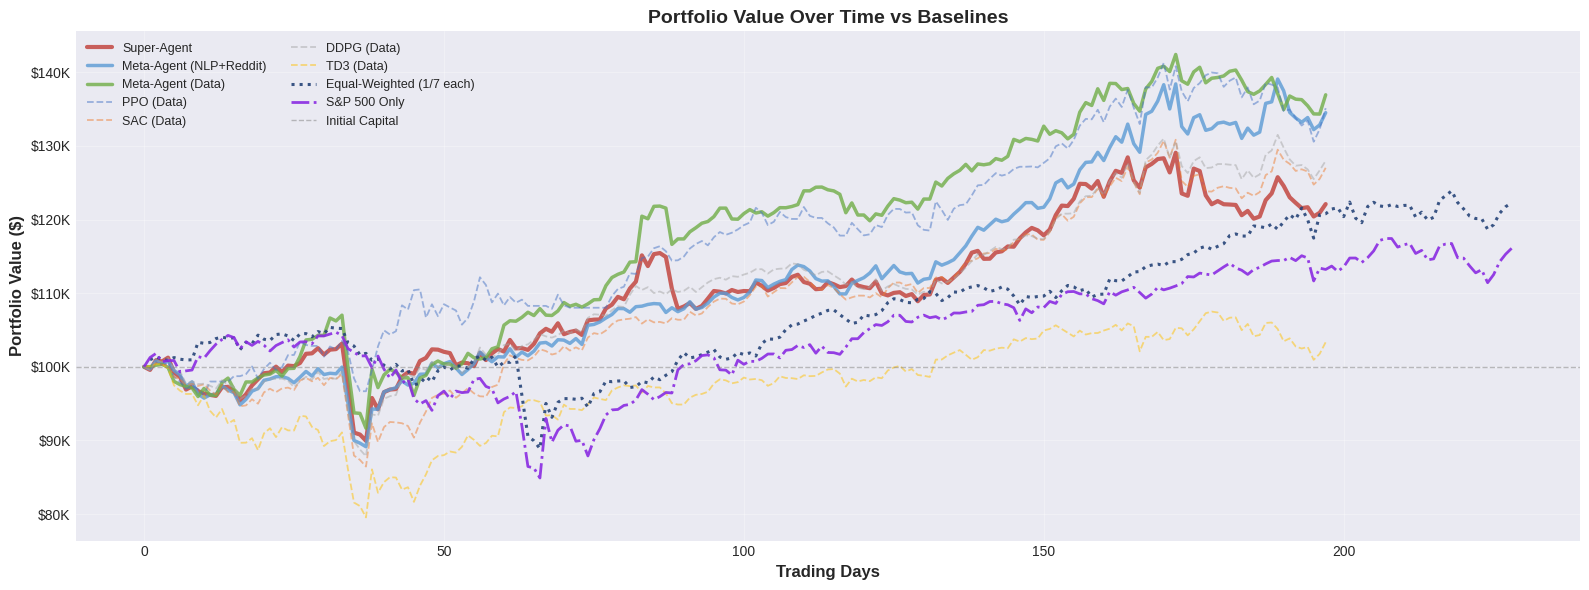

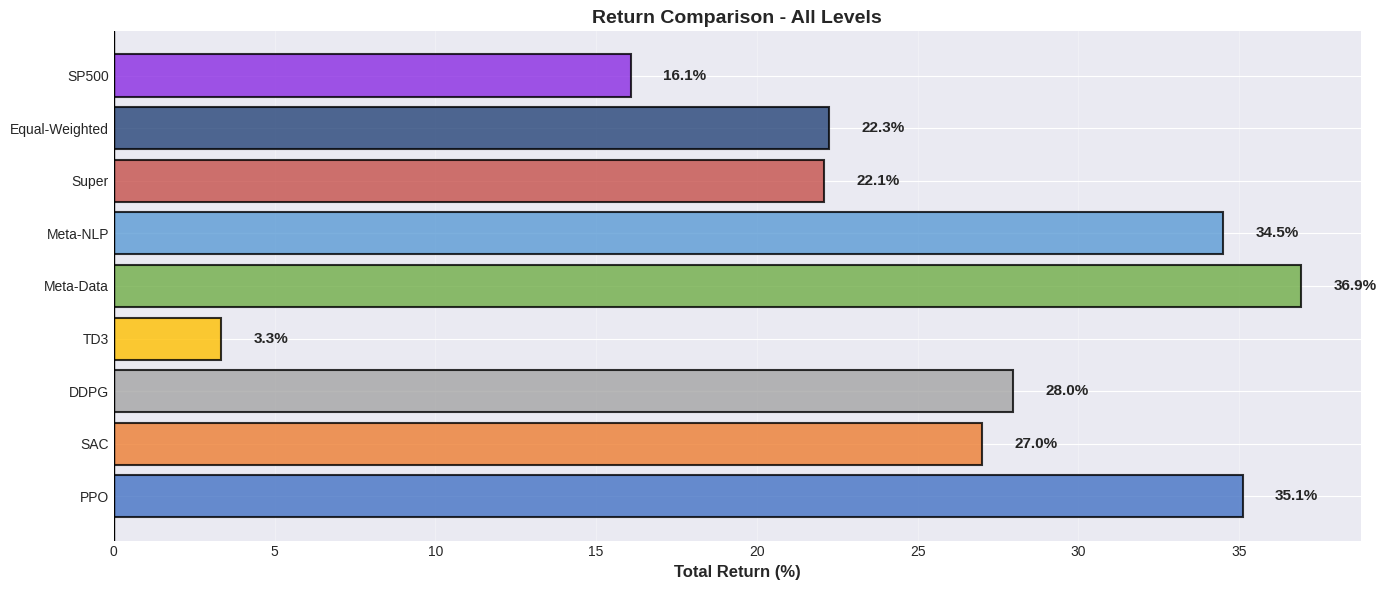

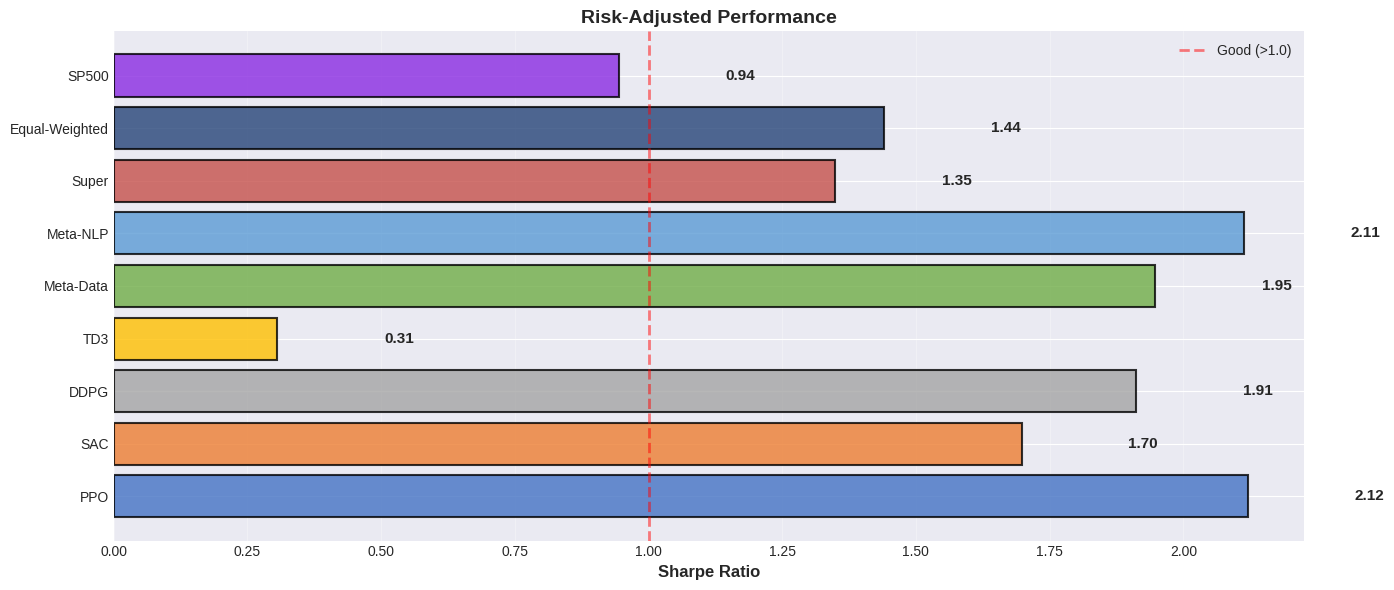

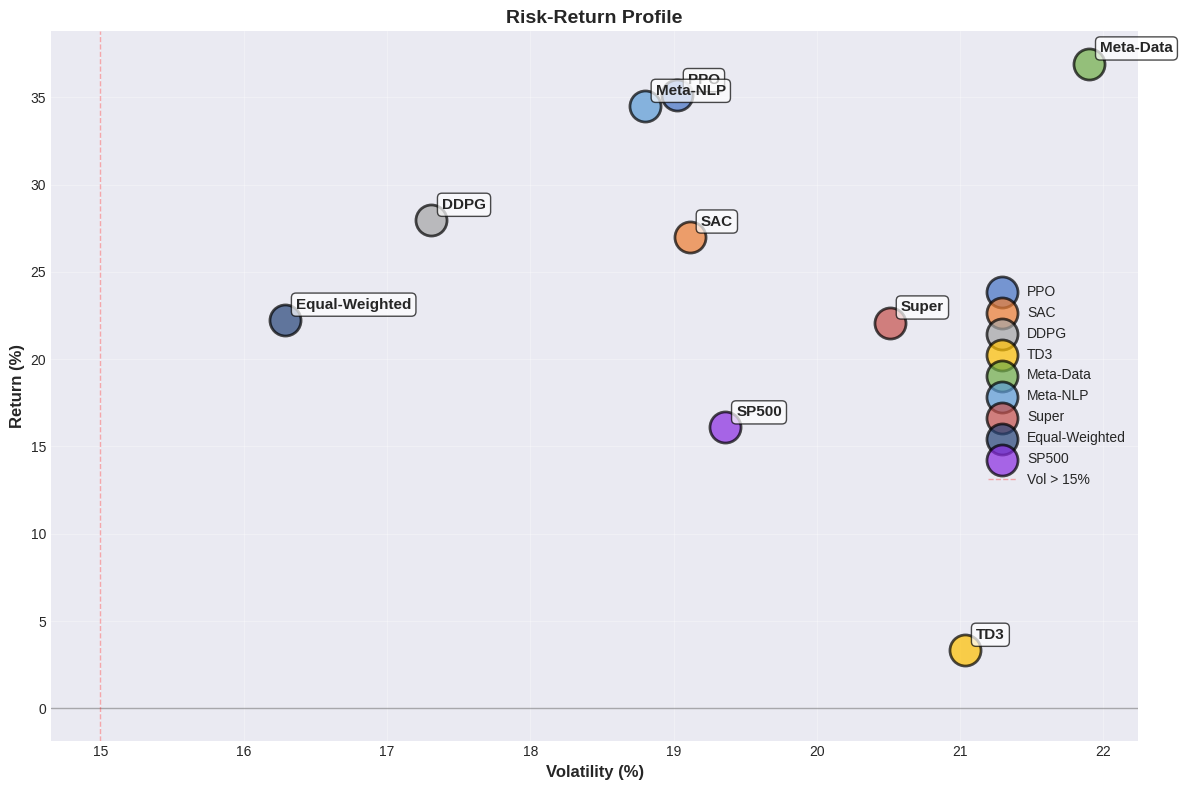

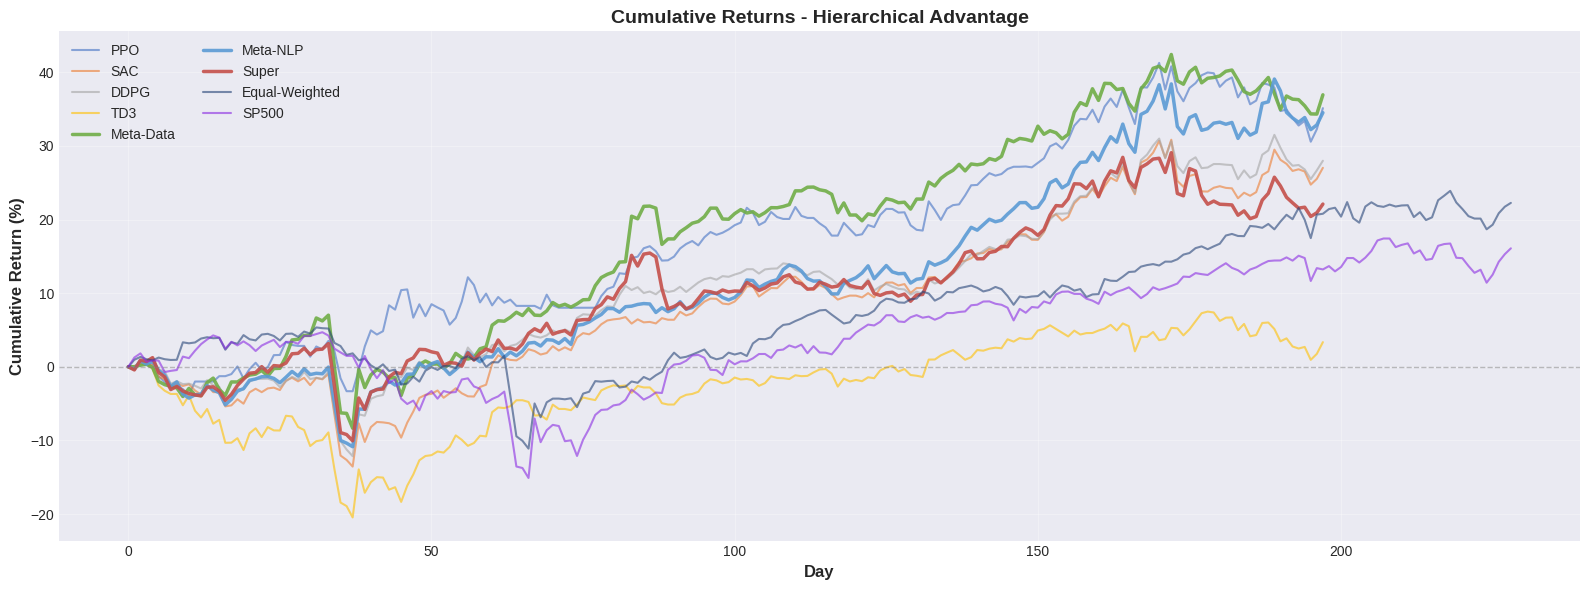

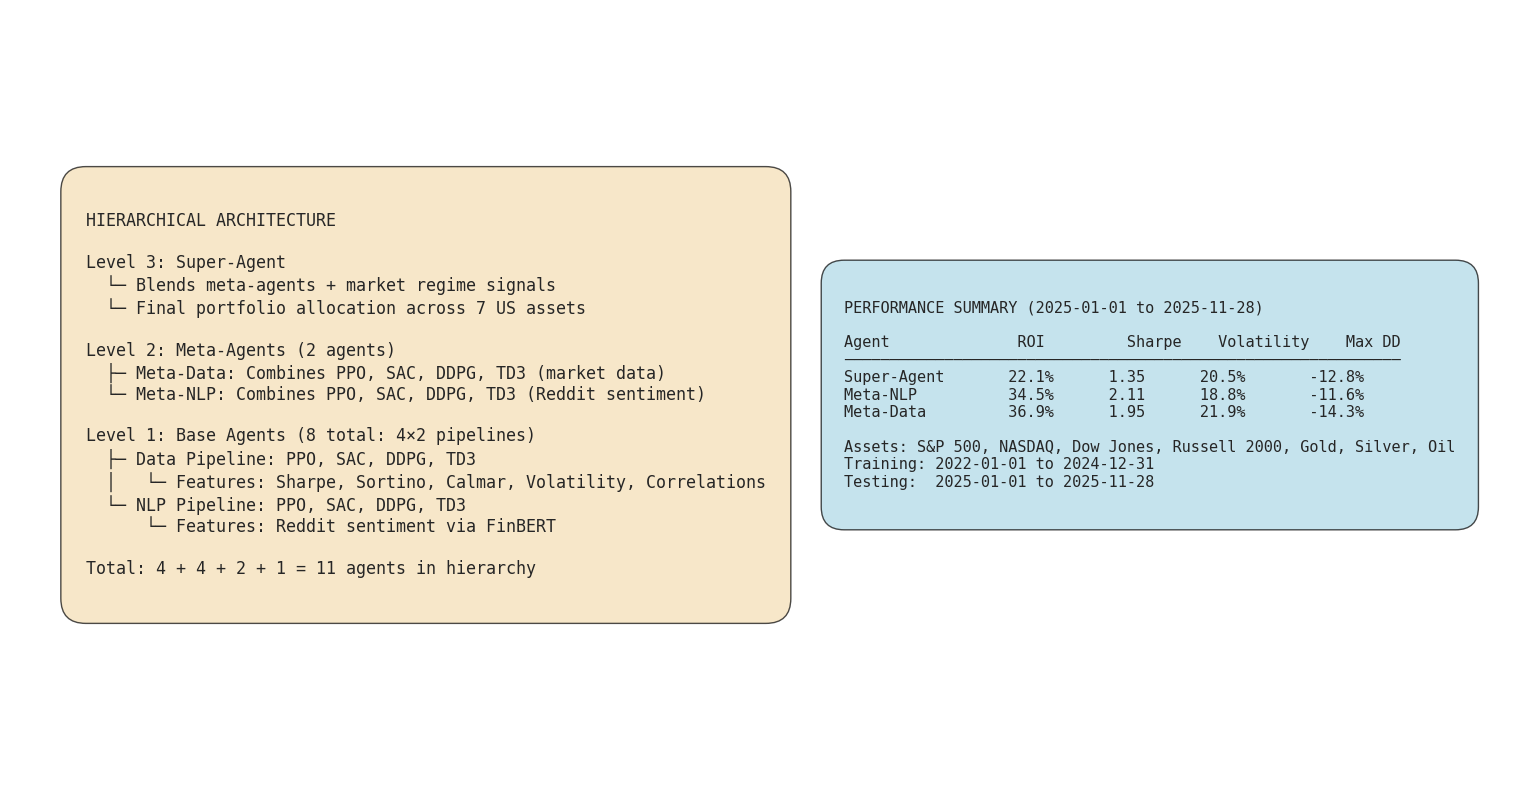


Saved files:
  1. plot1_portfolio_value.png      - Portfolio evolution over time
  2. plot2_return_comparison.png    - Bar chart of returns
  3. plot3_sharpe_ratios.png        - Risk-adjusted performance
  4. plot4_risk_return.png          - Scatter plot (risk vs return)
  5. plot5_cumulative_returns.png   - Cumulative return curves
  6. plot6_summary.png              - Architecture & performance table


In [29]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

colors = {
    'PPO': '#4472C4',
    'SAC': '#ED7D31',
    'DDPG': '#A5A5A5',
    'TD3': '#FFC000',
    'Meta_Data': '#70AD47',
    'Meta_NLP': '#5B9BD5',
    'Super': '#C5504B',
    'Equal_Weighted': '#264478',
    'SP500': '#8A2BE2'
}

# Portfolio Value Over Time
fig1, ax1 = plt.subplots(figsize=(16, 6))

initial_capital = 100000.0

# Super / meta / base agents
if 'values' in results.get('Super', {}):
    ax1.plot(results['Super']['values'], label='Super-Agent',
             linewidth=3, color=colors['Super'], alpha=0.9)
if 'values' in results.get('Meta_NLP', {}):
    ax1.plot(results['Meta_NLP']['values'], label='Meta-Agent (NLP+Reddit)',
             linewidth=2.5, color=colors['Meta_NLP'], alpha=0.8)
if 'values' in results.get('Meta_Data', {}):
    ax1.plot(results['Meta_Data']['values'], label='Meta-Agent (Data)',
             linewidth=2.5, color=colors['Meta_Data'], alpha=0.8)

for agent_name in ['PPO', 'SAC', 'DDPG', 'TD3']:
    key_data = f'{agent_name}_data'
    if key_data in results and 'values' in results[key_data]:
        ax1.plot(results[key_data]['values'],
                label=f'{agent_name} (Data)',
                linewidth=1.3, color=colors[agent_name], alpha=0.5, linestyle='--')

# Equal-weighted baseline
if test_prices is not None and not test_prices.empty:
    eq_returns = test_prices.pct_change().mean(axis=1)
    eq_values = (1 + eq_returns).cumprod().values * initial_capital
    ax1.plot(eq_values, label='Equal-Weighted (1/7 each)',
             linewidth=2.2, color=colors['Equal_Weighted'], alpha=0.9, linestyle=':')

    # S&P 500 baseline
    if 'SP500' in test_prices.columns:
        sp500_prices = test_prices['SP500']
        sp500_ret = sp500_prices.pct_change().fillna(0)
        sp500_values = (1 + sp500_ret).cumprod().values * initial_capital
        ax1.plot(sp500_values, label='S&P 500 Only',
                 linewidth=2, color=colors['SP500'], alpha=0.9, linestyle='-.')

# 100k line
ax1.axhline(y=initial_capital, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Initial Capital')

ax1.set_xlabel('Trading Days', fontsize=12, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)', fontsize=12, fontweight='bold')
ax1.set_title('Portfolio Value Over Time vs Baselines', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9, framealpha=0.9, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.savefig('plot1_portfolio_value_with_baselines.png', dpi=300, bbox_inches='tight')
plt.show()


# return comparison
fig2, ax2 = plt.subplots(figsize=(14, 6))

agents_to_plot = ['PPO', 'SAC', 'DDPG', 'TD3', 'Meta_Data', 'Meta_NLP', 'Super', 'Equal_Weighted', 'SP500']
agent_labels = []
agent_returns = []
agent_colors = []

for agent in agents_to_plot:
    # Try both data and nlp versions for base agents
    found = False
    for suffix in ['', '_data', '_nlp']:
        key = agent + suffix
        if key in results:
            agent_labels.append(agent.replace('_', '-'))
            agent_returns.append(results[key]['roi'])
            agent_colors.append(colors.get(agent, '#888888'))
            found = True
            break

# bar chart
bars = ax2.barh(agent_labels, agent_returns, color=agent_colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# value labels
for bar, value in zip(bars, agent_returns):
    width = bar.get_width()
    ax2.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{value:.1f}%', ha='left', va='center', fontweight='bold', fontsize=11)

ax2.set_xlabel('Total Return (%)', fontsize=12, fontweight='bold')
ax2.set_title('Return Comparison - All Levels', fontsize=14, fontweight='bold')
ax2.axvline(x=0, color='black', linewidth=1)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('plot2_return_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Risk-Adjusted Performance
fig3, ax3 = plt.subplots(figsize=(14, 6))

agent_sharpes = []
for agent in agents_to_plot:
    for suffix in ['', '_data', '_nlp']:
        key = agent + suffix
        if key in results:
            agent_sharpes.append(results[key]['sharpe'])
            break

bars = ax3.barh(agent_labels, agent_sharpes, color=agent_colors, alpha=0.8, edgecolor='black', linewidth=1.5)

for bar, value in zip(bars, agent_sharpes):
    width = bar.get_width()
    ax3.text(width + 0.2, bar.get_y() + bar.get_height()/2,
             f'{value:.2f}', ha='left', va='center', fontweight='bold', fontsize=11)

ax3.set_xlabel('Sharpe Ratio', fontsize=12, fontweight='bold')
ax3.set_title('Risk-Adjusted Performance', fontsize=14, fontweight='bold')
ax3.axvline(x=1.0, color='red', linewidth=2, linestyle='--', alpha=0.5, label='Good (>1.0)')
ax3.grid(axis='x', alpha=0.3)
ax3.legend(fontsize=10)

plt.tight_layout()
plt.savefig('plot3_sharpe_ratios.png', dpi=300, bbox_inches='tight')
plt.show()

# Risk-Return Profile
fig4, ax4 = plt.subplots(figsize=(12, 8))

for agent in agents_to_plot:
    for suffix in ['', '_data', '_nlp']:
        key = agent + suffix
        if key in results:
            vol = results[key]['volatility']
            ret = results[key]['roi']
            ax4.scatter(vol, ret, s=500, alpha=0.7,
                       color=colors.get(agent, '#888888'),
                       edgecolor='black', linewidth=2,
                       label=agent.replace('_', '-'))
            ax4.annotate(agent.replace('_', '-'),
                        (vol, ret),
                        xytext=(8, 8),
                        textcoords='offset points',
                        fontsize=11,
                        fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
            break

ax4.set_xlabel('Volatility (%)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Return (%)', fontsize=12, fontweight='bold')
ax4.set_title('Risk-Return Profile', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color='black', linewidth=1, alpha=0.3)
ax4.axvline(x=15, color='red', linewidth=1, linestyle='--', alpha=0.3, label='Vol > 15%')
ax4.legend(fontsize=10, loc='best')

plt.tight_layout()
plt.savefig('plot4_risk_return.png', dpi=300, bbox_inches='tight')
plt.show()

# Cumulative Returns
fig5, ax5 = plt.subplots(figsize=(16, 6))

# Calculate cumulative returns for each agent
for agent in agents_to_plot:
    for suffix in ['', '_data', '_nlp']:
        key = agent + suffix
        if key in results and 'values' in results[key]:
            values = np.array(results[key]['values'])
            cum_returns = ((values / values[0]) - 1) * 100
            ax5.plot(cum_returns, label=agent.replace('_', '-'),
                    linewidth=2.5 if 'Meta' in agent or agent == 'Super' else 1.5,
                    color=colors.get(agent, '#888888'),
                    alpha=0.9 if 'Meta' in agent or agent == 'Super' else 0.6)
            break

ax5.set_xlabel('Day', fontsize=12, fontweight='bold')
ax5.set_ylabel('Cumulative Return (%)', fontsize=12, fontweight='bold')
ax5.set_title('Cumulative Returns - Hierarchical Advantage', fontsize=14, fontweight='bold')
ax5.legend(fontsize=10, loc='upper left', ncol=2)
ax5.grid(True, alpha=0.3)
ax5.axhline(y=0, color='gray', linewidth=1, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('plot5_cumulative_returns.png', dpi=300, bbox_inches='tight')
plt.show()

# Architecture & Performance Summary
fig6, ax6 = plt.subplots(figsize=(16, 8))
ax6.axis('off')

# architecture breakdown
architecture_text = """
HIERARCHICAL ARCHITECTURE

Level 3: Super-Agent
  └─ Blends meta-agents + market regime signals
  └─ Final portfolio allocation across 7 US assets

Level 2: Meta-Agents (2 agents)
  ├─ Meta-Data: Combines PPO, SAC, DDPG, TD3 (market data)
  └─ Meta-NLP: Combines PPO, SAC, DDPG, TD3 (Reddit sentiment)

Level 1: Base Agents (8 total: 4×2 pipelines)
  ├─ Data Pipeline: PPO, SAC, DDPG, TD3
  │   └─ Features: Sharpe, Sortino, Calmar, Volatility, Correlations
  └─ NLP Pipeline: PPO, SAC, DDPG, TD3
      └─ Features: Reddit sentiment via FinBERT

Total: 4 + 4 + 2 + 1 = 11 agents in hierarchy
"""

ax6.text(0.05, 0.5, architecture_text,
        fontsize=12,
        family='monospace',
        verticalalignment='center',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7, pad=1.5))

# performance summary table
summary_text = f"""
PERFORMANCE SUMMARY ({config.TEST_START} to {config.TEST_END})

Agent              ROI         Sharpe    Volatility    Max DD
─────────────────────────────────────────────────────────────
Super-Agent     {results['Super']['roi']:>6.1f}%     {results['Super']['sharpe']:>5.2f}     {results['Super']['volatility']:>5.1f}%       {results['Super'].get('max_drawdown', 0):>5.1f}%
Meta-NLP        {results['Meta_NLP']['roi']:>6.1f}%     {results['Meta_NLP']['sharpe']:>5.2f}     {results['Meta_NLP']['volatility']:>5.1f}%       {results['Meta_NLP'].get('max_drawdown', 0):>5.1f}%
Meta-Data       {results['Meta_Data']['roi']:>6.1f}%     {results['Meta_Data']['sharpe']:>5.2f}     {results['Meta_Data']['volatility']:>5.1f}%       {results['Meta_Data'].get('max_drawdown', 0):>5.1f}%

Assets: S&P 500, NASDAQ, Dow Jones, Russell 2000, Gold, Silver, Oil
Training: {config.TRAIN_START} to {config.TRAIN_END}
Testing:  {config.TEST_START} to {config.TEST_END}
"""

ax6.text(0.55, 0.5, summary_text,
        fontsize=11,
        family='monospace',
        verticalalignment='center',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7, pad=1.5))

plt.tight_layout()
plt.savefig('plot6_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved files:")
print("  1. plot1_portfolio_value.png      - Portfolio evolution over time")
print("  2. plot2_return_comparison.png    - Bar chart of returns")
print("  3. plot3_sharpe_ratios.png        - Risk-adjusted performance")
print("  4. plot4_risk_return.png          - Scatter plot (risk vs return)")
print("  5. plot5_cumulative_returns.png   - Cumulative return curves")
print("  6. plot6_summary.png              - Architecture & performance table")


In [30]:
# Final Summary
print("\n" + "=" * 80)
print("FINAL SUMMARY - HARLF")
print("=" * 80)

print(f"\nTraining Period: {config.TRAIN_START} to {config.TRAIN_END}")
print(f"Testing Period:  {config.TEST_START} to {config.TEST_END}")
print(f"Assets: {config.N_ASSETS} US-focused instruments")
print(f"Architecture: 8 base agents → 2 meta-agents → 1 super-agent")

super_metrics = results['Super']
eq_metrics = results.get('Equal_Weighted', None)
sp500_metrics = results.get('SP500', None)

print(f"\nBest Performing Agent: Super-Agent")
print(f"Total ROI:        {super_metrics['roi']:.2f}%")
print(f"Annualized ROI:   {super_metrics['annualized_roi']:.2f}%")
print(f"Sharpe Ratio:     {super_metrics['sharpe']:.2f}")
print(f"Volatility:       {super_metrics['volatility']:.1f}%")
print(f"Max Drawdown:     {super_metrics['max_drawdown']:.1f}%")

if eq_metrics is not None:
    improvement_eq = super_metrics['annualized_roi'] - eq_metrics['annualized_roi']
    print(f"\nVs Equal-Weighted (1/7 each):")
    print(f"Equal-Weighted Annualized ROI: {eq_metrics['annualized_roi']:.2f}%")
    print(f"Equal-Weighted Sharpe:         {eq_metrics['sharpe']:.2f}")
    print(f"Outperformance (ROI):          +{improvement_eq:.2f}%")

if sp500_metrics is not None:
    improvement_sp = super_metrics['annualized_roi'] - sp500_metrics['annualized_roi']
    print(f"\nVs S&P 500:")
    print(f"   S&P 500 Annualized ROI:        {sp500_metrics['annualized_roi']:.2f}%")
    print(f"   S&P 500 Sharpe:                {sp500_metrics['sharpe']:.2f}")
    print(f"   Outperformance (ROI):          +{improvement_sp:.2f}%")



FINAL SUMMARY - HARLF

Training Period: 2022-01-01 to 2024-12-31
Testing Period:  2025-01-01 to 2025-11-28
Assets: 7 US-focused instruments
Architecture: 8 base agents → 2 meta-agents → 1 super-agent

Best Performing Agent: Super-Agent
Total ROI:        22.09%
Annualized ROI:   29.09%
Sharpe Ratio:     1.35
Volatility:       20.5%
Max Drawdown:     -12.8%

Vs Equal-Weighted (1/7 each):
Equal-Weighted Annualized ROI: 24.87%
Equal-Weighted Sharpe:         1.44
Outperformance (ROI):          +4.22%

Vs S&P 500:
   S&P 500 Annualized ROI:        17.92%
   S&P 500 Sharpe:                0.94
   Outperformance (ROI):          +11.17%
